# Clasificación rápida en ALeRCE utilizando selección de características y algoritmos genéticos.

Integrantes: Joaquín Cubelli - Tomás de la Sotta

Profesor de Cátedra: Pablo Estévez<br>
Profesor Auxiliar: Ignacio Reyes<br>
Ayudantes: Francisca Cona, Jhon Intriago, Pablo Montero, Óscar Pimentel, Esteban Reyes, Mauricio Romero

El broker astronómico ALeRCE clasifica objetos en tiempo real todas las noches. Para ello utiliza dos modelos, un clasificador basado en estampillas para detección rápida de transientes y un clasificador basado en curvas de luz que utiliza una taxonomía detallada. El clasificador de curvas de luz, descrito en Sánchez-Sáez et al. (2020), consiste en la extracción de múltiples características a partir de las curvas de luz (y otras fuentes de datos) y un modelo basado en Random Forests.

El objetivo de este proyecto es reducir el número de características utilizadas por el clasificador de curvas de luz de ALeRCE, explorando el compromiso entre el desempeño en clasificación y el costo computacional asociado.

La primera etapa del proyecto consiste en **evaluar la estrategia greedy para seleccionar las características más relevantes al momento de clasificar**. En esta estrategia se explorará una característica a la vez, buscando cuál de ellas ayuda más al desempeño del modelo cuando es agregada al conjunto de características utilizadas. También se deberá probar comenzando con todas las características y removiendo una característica a la vez. 

La segunda etapa consiste en **formular el problema como la optimización de una figura de mérito y resolver mediante algoritmos genéticos**. Lo que *se busca minimizar son dos cantidades, el error de clasificación y el tiempo requerido para la clasificación*. Se propone construir una función de fitness que combine ambos costos y luego explorar el frente de Pareto modificando la manera en que se ponderan ambos términos.

Ref: Sánchez-Sáez, P., et al. "Alert Classification for the ALeRCE Broker System: The Light Curve Classifier." arXiv preprint arXiv:2008.03311 (2020).
Ref: Huang, Cheng-Lung, and Chieh-Jen Wang. "A GA-based feature selection and parameters optimization for support vector machines." Expert Systems with applications 31.2 (2006): 231-240. Nota: Tomar como referencia, no como pauta a la cual seguir al pie de la letra. 

Proyecto semestral: https://docs.google.com/document/d/1pz1Yua5fkzJQAhDPjIAwJjJXUPnKswe7gRMs_D2-ixA/edit

Requisitos entrega Intermedia: https://docs.google.com/document/d/1kgTPnFyniYfJPlIaA2JUxTBbzQ6Erax6sKyxXOmG-0Q/edit

Indicaciones proyecto: https://docs.google.com/document/d/10-ZcclkeuGaviFsalC4wnTtrZMiitumQKaUmijk1tsA/edit

## Imports de librerías y otros archivos de python

In [1]:
# Correr una vez.

# !pip install --upgrade pip
# !pip install pyarrow
# !pip install -U imbalanced-learn

In [2]:
# Imports:
from dicts.features_packs import feature_packs
from dicts.banned_features import banned_features
from dicts.Dict import Dict
from dataset_creation import *

# Procesamiento de datos.
from pathlib import Path
import os.path

import matplotlib as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq

# import tensorflow as tf
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier

# Resultados

from imblearn.metrics import sensitivity_specificity_support as sss
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn.model_selection import cross_validate
    #import itertools
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

from bins.Tree import get_tree_data

In [3]:
#dataset = get_dataset(Joaquin = False) # Ejecutar si no existe el dataset, y mover el csv al directorio padre (>100 MB, no entra en github).

In [4]:
dataset = pd.read_csv('../ALeRCE.csv') # Se ejecuta el archivo en el directorio padre.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(dataset.select_dtypes(include=[np.number]), dataset['classALeRCE'], test_size=0.33, random_state=42)

## Clasificador inicial, para ver el ranking de features para realizar el feature selection.

In [6]:
clf=BalancedRandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            class_weight=None,
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

clf.fit(X_train, y_train)

BalancedRandomForestClassifier(criterion='entropy', n_estimators=500, n_jobs=-1)

In [7]:
y_pred = clf.predict(X_test)

classes = clf.classes_

featuresCopy = np.copy(dataset.columns[1:])
featuresCopy = np.delete(featuresCopy, np.where(featuresCopy == 'classALeRCE'))

fI = clf.feature_importances_
feature_importance = np.copy(fI)

In [8]:
ImportanceRank = []

while not np.all(fI == -1):
    maxArg = np.argmax(fI)
    ImportanceRank.append(featuresCopy[maxArg])
    fI[maxArg] = -1

Visualizemos tanto la estructura del árbol (https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c) y de las distintas features, y analizaremos los datos (https://medium.com/@smollaha/imbalanced-data-visualization-and-random-forest-25cbff51f711)

Text(30.5, 0.5, 'True label')

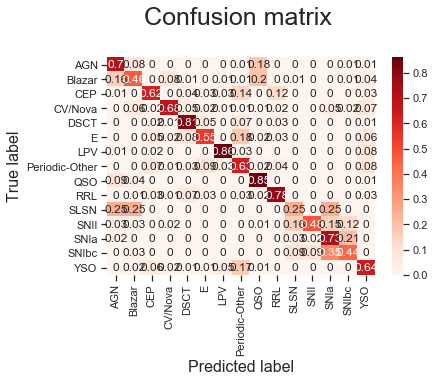

In [9]:
cm = confusion_matrix(y_test, y_pred) 
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

df = pd.DataFrame(np.round(cm, 2), index = classes, columns = classes)

g = sns.heatmap(df, annot=True, cmap="Reds")

plt.rcParams["figure.figsize"] = (10,10)

g.set_yticklabels(g.get_yticklabels(), rotation = 0)

#Estandar en 20, 20

plt.title('Confusion matrix \n', size=25)
plt.xlabel('Predicted label', size=16)
plt.ylabel('True label', size=16)



In [10]:
scoring = ['precision_macro', 'recall_macro', 'accuracy', 'f1_macro']

precision = precision_score(y_test, y_pred, average = 'weighted')
recall = recall_score(y_test, y_pred, average = 'weighted')
f1 = f1_score(y_test, y_pred, average = 'weighted')
accuracy = accuracy_score(y_test, y_pred)

print('Precision: {}  ({}%)'.format(precision, int(precision*100)))
print('Recall:    {}  ({}%)'.format(recall, int(recall*100)))
print('F1-score:  {}  ({}%)'.format(f1, int(f1*100)))
print('Accuracy:  {}  ({}%)'.format(accuracy, int(accuracy*100)))

Precision: 0.8768401177134098  (87%)
Recall:    0.7142491423890226  (71%)
F1-score:  0.7680673092311997  (76%)
Accuracy:  0.7142491423890226  (71%)


## Feature selection greedy:

- Tener implementado feature selection greedy basado en la importancia dada por Random Forest. Mostrar curva accuracy vs número de packs y accuracy vs tiempo de cómputo asociado.

In [11]:
train = False
ThreadAccuracy, ThreadPrecision, ThreadRecall, Threadf1 = get_tree_data(dataset, ImportanceRank, train)

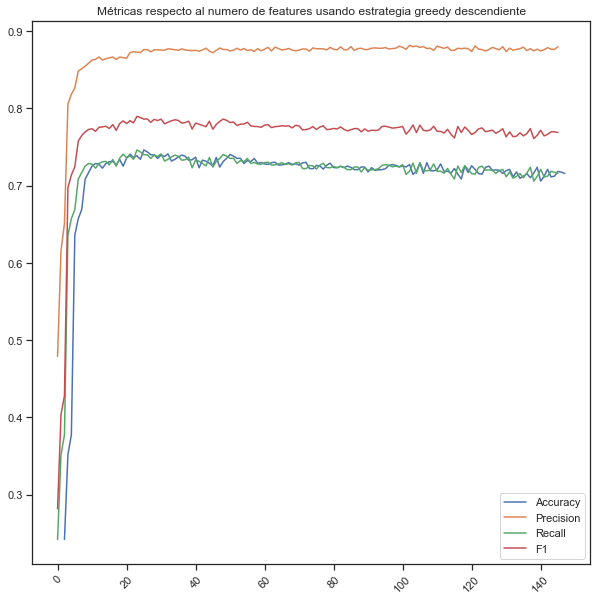

In [12]:
plt.plot(np.arange(2,148), ThreadAccuracy)
plt.plot(ThreadPrecision)
plt.plot(ThreadRecall)
plt.plot(Threadf1)
plt.legend(('Accuracy', 'Precision', 'Recall', 'F1'))
plt.title('Métricas respecto al numero de features usando estrategia greedy descendiente')
plt.xticks(rotation=45)
plt.show()

In [13]:
# Codigo no optimizado por Joaquin que realiza el feature selection por característica (at least works).

featuresCopy = np.copy(dataset.columns[1:])
featuresCopy = np.delete(featuresCopy, np.where(featuresCopy == 'classALeRCE'))

Importancia = pd.DataFrame(clf.feature_importances_, columns=['Importancia'])
Importancia.index = featuresCopy

fImax=[]
packsNames=[]
time=[]
for i in feature_packs:
    frac = 0
    for j in range(len(feature_packs[i])-1):
        frac += Importancia.loc[feature_packs[i][j]]['Importancia']
    time.append(feature_packs[i][-1])
    fImax.append(frac)
    packsNames.append(i)
    
I_Packs = pd.DataFrame(fImax, columns=['Importancia'], index=packsNames)
I_Packs['Tiempo'] = time

accuracy = []
f1 = []
precision = []
recall = []
tiempo = []

ImportanciaRank = I_Packs

pass

for i in range(len(I_Packs['Importancia'])):
    print('Packs usados: '+str(len(ImportanciaRank)))
    selected_features = []
    t = 0
    for i in ImportanciaRank.index:
        for j in range(len(feature_packs[i])-1):
            selected_features.append(feature_packs[i][j])
        t+=feature_packs[i][-1]
    tiempo.append(t)
    print('Numero de features: '+str(len(selected_features)))
    X_train2 = X_train[selected_features]
    X_test2 = X_test[selected_features]
    clf.fit(X_train2, y_train)
    y_pred = clf.predict(X_test2)
    a_score = accuracy_score(y_test, y_pred)
    f_score = f1_score(y_test, y_pred, average='macro')
    p_score = precision_score(y_test, y_pred, average='macro')
    r_score = recall_score(y_test, y_pred, average='macro')
    ImportanciaRank = ImportanciaRank.loc[ImportanciaRank['Importancia']!=ImportanciaRank['Importancia'].min()]
    accuracy.insert(0, a_score)
    f1.insert(0, f_score)
    precision.insert(0, p_score)
    recall.insert(0, r_score)
    print('Accuracy:  {}  ({}%)'.format(a_score, int(a_score*100)))
    print('Precision:  {}  ({}%)'.format(p_score, int(p_score*100)))
    print('Recall:  {}  ({}%)'.format(r_score, int(r_score*100)))
    print('F1-score:  {}  ({}%)'.format(f_score, int(f_score*100)))
    print('')
    if len(ImportanciaRank)>0:
        print('Pack Eliminado: ',ImportanciaRank.loc[ImportanciaRank['Importancia']==ImportanciaRank['Importancia'].min()].index[0])

Packs usados: 36
Numero de features: 148


KeyboardInterrupt: 

In [ ]:
plt.plot(np.arange(1,37), accuracy)
plt.plot(precision)
plt.plot(recall)
plt.plot(f1)
plt.legend(('Accuracy', 'Precision', 'Recall', 'F1'))
plt.title('Métricas respecto al numero de features usando estrategia greedy descendiente para distintos packs de características')
plt.xticks(rotation=45)
plt.show()

In [ ]:
plt.plot(tiempo, accuracy[::-1])
plt.plot(tiempo, precision[::-1])
plt.plot(tiempo, recall[::-1])
plt.plot(tiempo, f1[::-1])
plt.legend(('Accuracy', 'Precision', 'Recall', 'F1'))
plt.title('Métricas respecto al numero de features usando estrategia greedy descendiente para tiempos de computo totales')
plt.xticks(rotation=45)
plt.show()

In [ ]:
tiempo

## Algoritmo Genético:

Se utiliza la librería DEAP para realizar la búsqueda de features utilizando algoritmos geneticos, para esto, se tienen en cuenta los siguientes parámetros para la función de fitness; el accuracy y el tiempo de computo. Se busca maximizar el accuracy y minimizar el tiempo de computo de los packs de features utilizados.
En el diccionario feature_packs, bajo cada feature pack, se encuentra el tiempo de cómputo en el ultimo elemento.

- Implementar selección de características con algoritmos genéticos y probarlo. Obtener resultados preliminares y construir curvas para comparar con estrategia greedy. Reportar curvas de fitness vs generaciones con mejor fitness, peor fitness y fitness promedio.
- Revisar material de estudio para entender conceptos básicos de algoritmos genéticos. Si tienen cualquier duda contáctenme.
- Al parecer la librería más popular de computación evolutiva en python es DEAP https://deap.readthedocs.io/en/master/ Siempre pueden implementar la optimización con algoritmos genéticos desde cero, pero es más fácil si se apoyan en una librería.
- Les recomiendo usar para el genotipo una codificación binaria, donde cada bit indica si un pack está presente o no.
- En la función de fitness van a tener que entrenar el RF con los packs indicados por el genotipo y luego calcular el accuracy (o la métrica que elijan para indicar performance de clasificación). Después deberán calcular el costo computacional de los features usados. Finalmente deben construir un puntaje de fitness combinando ambos valores (transformar en un problema mono-objetivo), teniendo cuidado de que las escalas de ambos términos sean comparables para que ambos contribuyan en el proceso de optimización.

Joaquín - Encontré la implementación de DEAP con una regresion logistica 

In [14]:
from deap import creator, base, tools, algorithms
import random
import math

In [15]:
AllPacks = [] # Como no se puede llamar al diccionario por indice, se crea una lista que soluciona ese problema.
for pack in feature_packs:
    AllPacks.append(pack)

In [16]:
def getFitness(individual, X_train, X_test, y_train, y_test):
    # Packs de caracteristicas a utilizar.
    packs = [AllPacks[index] for index in range(len(individual)) if individual[index] == 1]
    cols = []
    t = 0
    for i in packs:
        for j in range(len(feature_packs[i])-1):
            cols.append(feature_packs[i][j])
        t+=feature_packs[i][-1]
    X_trainParsed = X_train[cols]
    X_testParsed = X_test[cols]
    # Entrenar y evaluar
    clf.fit(X_trainParsed, y_train)
    y_pred = clf.predict(X_testParsed)
    accuracy = accuracy_score(y_test, y_pred)
    
    fitness = accuracy*-math.log(t, 10)
    
    return (fitness, )

In [17]:
#========DEAP GLOBAL VARIABLES (viewable by SCOOP)========

# Create Individual
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Create Toolbox
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, len(feature_packs))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Continue filling toolbox...
toolbox.register("evaluate", getFitness, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [18]:
def getHof(): # Hall of fame

    # Initialize variables to use eaSimple
    numPop = 100
    numGen = 10
    pop = toolbox.population(n=numPop)
    hof = tools.HallOfFame(numPop * numGen)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # Launch genetic algorithm
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=numGen, stats=stats, halloffame=hof, verbose=True)

    # Return the hall of fame
    return hof

In [19]:
def getMetrics(hof):

    # Get list of percentiles in the hall of fame
    percentileList = [i / (len(hof) - 1) for i in range(len(hof))]
    
    # Gather fitness data from each percentile
    testAccuracyList = []
    validationAccuracyList = []
    individualList = []
    for individual in hof:
        testAccuracy = individual.fitness.values
        validationAccuracy = getFitness(individual, X_trainAndTest, X_validation, y_trainAndTest, y_validation)
        testAccuracyList.append(testAccuracy[0])
        validationAccuracyList.append(validationAccuracy[0])
        individualList.append(individual)
    testAccuracyList.reverse()
    validationAccuracyList.reverse()
    return testAccuracyList, validationAccuracyList, individualList, percentileList

In [20]:
dataset.drop(['classALeRCE'], axis=1)

,Unnamed: 0,index,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,...,median_diffmaglim_before_fid_1,median_diffmaglim_before_fid_2,n_non_det_after_fid_1,n_non_det_after_fid_2,n_non_det_before_fid_1,n_non_det_before_fid_2,positive_fraction_1,positive_fraction_2,rb,sgscore1
0,0,ZTF17aaabgdt,0.272255,-1.000000,0.157961,-1.000000,0.000000,-1.000000,0.285786,-1.000000,...,-1.000000,-1.000000,0.164665,-1.000000,0.000000,-1.000000,0.497497,-1.000000,0.676176,0.203603
1,1,ZTF17aaadfsa,0.332273,0.341394,0.763764,0.831331,0.781782,0.000000,0.687688,0.884384,...,-1.000000,-1.000000,0.539039,0.699199,0.000000,0.000000,0.474824,0.557057,0.470971,0.486486
2,2,ZTF17aaadxdb,0.433682,0.670880,1.000000,0.655606,0.000000,0.000000,0.901401,0.529029,...,-1.000000,-1.000000,0.815315,0.876376,0.000000,0.000000,0.453954,0.487487,0.169169,0.287190
3,3,ZTF17aaadzlq,0.991577,0.989059,1.000000,1.000000,0.983483,0.987487,0.944269,0.882426,...,-1.000000,-1.000000,0.562062,0.406406,0.000000,0.000000,0.240079,0.225568,0.493994,0.200353
4,4,ZTF17aaaenfy,0.723593,0.820105,1.000000,1.000000,0.000000,0.000000,0.492815,0.403904,...,0.913189,-1.000000,0.894895,0.829830,0.397397,0.000000,0.640255,0.537720,0.804304,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118363,118464,ZTF20aauowvs,0.171989,0.120566,0.174193,0.220535,0.000000,0.000000,0.193694,0.232733,...,0.405996,0.043925,0.277277,0.280280,0.599600,0.423924,1.000000,1.000000,0.614114,1.000000
118364,118465,ZTF20aawxcal,0.075113,-1.000000,0.259123,-1.000000,0.000000,-1.000000,0.748248,-1.000000,...,0.767696,0.628627,0.744244,0.509009,0.982983,0.997452,0.000000,0.000000,0.993994,0.358358
118365,118466,ZTF20abawiqv,0.018110,-1.000000,0.072725,-1.000000,0.000000,-1.000000,0.285786,-1.000000,...,0.816650,-1.000000,0.183183,-1.000000,0.793293,-1.000000,1.000000,-1.000000,0.976977,0.018846
118366,118467,ZTF20abcxmfu,0.339575,0.255028,0.158826,0.068803,0.913914,0.950450,0.247247,0.514515,...,-1.000000,-1.000000,0.015015,0.000000,0.000000,0.000000,1.000000,1.000000,0.947948,0.257657


In [ ]:
if __name__ == '__main__':

    '''
    First, we will apply logistic regression using all the features to acquire a baseline accuracy.
    '''
    individual = [1 for i in range(len(feature_packs))]
    testAccuracy = getFitness(individual, X_train, X_test, y_train, y_test)
    validationAccuracy = getFitness(individual, X_train, X_test, y_train, y_test)
    print('\nFitness with all features: \t' + str(testAccuracy[0]))

    '''
    Now, we will apply a genetic algorithm to choose a subset of features that gives a better accuracy than the baseline.
    '''
    hof = getHof()
    testAccuracyList, validationAccuracyList, individualList, percentileList = getMetrics(hof) # Esta fallando acá. 
                                                # Falta definir feature_packs por fuera del archivo de alguna forma (?).

    # Get a list of subsets that performed best on validation data
    maxValAccSubsetIndicies = [index for index in range(len(validationAccuracyList)) if validationAccuracyList[index] == max(validationAccuracyList)]
    maxValIndividuals = [individualList[index] for index in maxValAccSubsetIndicies]
    maxValSubsets = [[list(allFeatures)[index] for index in range(len(individual)) if individual[index] == 1] for individual in maxValIndividuals]

    print('\n---Optimal Feature Subset(s)---\n')
    for index in range(len(maxValAccSubsetIndicies)):
        print('Percentile: \t\t\t' + str(percentileList[maxValAccSubsetIndicies[index]]))
        print('Validation Accuracy: \t\t' + str(validationAccuracyList[maxValAccSubsetIndicies[index]]))
        print('Individual: \t' + str(maxValIndividuals[index]))
        print('Number Features In Subset: \t' + str(len(maxValSubsets[index])))
        print('Feature Subset: ' + str(maxValSubsets[index]))

    '''
    Now, we plot the test and validation classification accuracy to see how these numbers change as we move from our worst feature subsets to the 
    best feature subsets found by the genetic algorithm.
    '''
    # Calculate best fit line for validation classification accuracy (non-linear)
    tck = interpolate.splrep(percentileList, validationAccuracyList, s=5.0)
    ynew = interpolate.splev(percentileList, tck)

    e = plt.figure(1)
    plt.plot(percentileList, validationAccuracyList, marker='o', color='r')
    plt.plot(percentileList, ynew, color='b')
    plt.title('Validation Set Classification Accuracy vs. \n Continuum with Cubic-Spline Interpolation')
    plt.xlabel('Population Ordered By Increasing Test Set Accuracy')
    plt.ylabel('Validation Set Accuracy')
    e.show()

    f = plt.figure(2)
    plt.scatter(percentileList, validationAccuracyList)
    plt.title('Validation Set Classification Accuracy vs. Continuum')
    plt.xlabel('Population Ordered By Increasing Test Set Accuracy')
    plt.ylabel('Validation Set Accuracy')
    f.show()

    g = plt.figure(3)
    plt.scatter(percentileList, testAccuracyList)
    plt.title('Test Set Classification Accuracy vs. Continuum')
    plt.xlabel('Population Ordered By Increasing Test Set Accuracy')
    plt.ylabel('Test Set Accuracy')
    g.show()

    input()



Test accuracy with all features: 	0.4146951156941636
